In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn

import dataloader
import trainer
import visualizer

## Main Functions

Auto-reload files imported to the notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [4]:
TILE_HEIGHT, TILE_WIDTH = 480, 640

For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

In [5]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = dataloader.main(TILE_HEIGHT, TILE_WIDTH, batch_size=10, num_workers=3)

In [6]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

## Resnet18 Without tiles and utilizing the full dataset

Here we import the resnet18 model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch.

In [7]:
resnet18_notile_full = models.resnet18(pretrained=True)

From there, we replace the last layer to work with the tiles format rather than Resnet's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [8]:
resnet18_notile_full.fc = nn.Linear(512, TILE_HEIGHT*TILE_WIDTH)
print(resnet18_notile_full.fc)

Linear(in_features=512, out_features=307200, bias=True)


##### NOTE: If you want to load the saved model then skip then section and run from the Visualize Model section

In [9]:
for param in resnet18_notile_full.parameters():
    param.require_grad = False
resnet18_notile_full.fc.requires_grad_(True)

Linear(in_features=512, out_features=307200, bias=True)

Now let's train the model!

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full = resnet18_notile_full.to(device)
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

Device: cuda
Training epoch 1 batch 200/2500, train loss = 0.132081, train acc = 0.966279, recall = 0.025317, precision = nan8154
validation metrics at epoch 1 batch 200: val loss = 0.043539, val acc = 0.990325, val recall = 0.000000, val precision = nan
Training epoch 1 batch 400/2500, train loss = 0.085843, train acc = 0.978324, recall = 0.012658, precision = nan
validation metrics at epoch 1 batch 400: val loss = 0.036840, val acc = 0.990325, val recall = 0.000000, val precision = nan
Training epoch 1 batch 600/2500, train loss = 0.069081, train acc = 0.982417, recall = 0.008439, precision = nan
validation metrics at epoch 1 batch 600: val loss = 0.035155, val acc = 0.990325, val recall = 0.000000, val precision = nan
Training epoch 1 batch 800/2500, train loss = 0.060176, train acc = 0.984507, recall = 0.006333, precision = nan
validation metrics at epoch 1 batch 800: val loss = 0.032996, val acc = 0.990325, val recall = 0.000105, val precision = nan
Training epoch 1 batch 1000/250

([0.043539162886639435,
  0.03684039166818062,
  0.03515528419365486,
  0.03299618856360515,
  0.03071596716841062,
  0.02717122987533609,
  0.023021726676573356,
  0.01989664324869712,
  0.018919155585269132,
  0.016828226689249277,
  0.015721366548289855,
  0.01481555849313736,
  0.014508480696628492,
  0.014340464938431979,
  0.013507787020256122,
  0.012918422417715191,
  0.012864836274335783,
  0.01257688934604327,
  0.011558012611543138,
  0.011106119429071745,
  0.010749148428440094,
  0.010276548070833088,
  0.010486674060424169,
  0.009831760755429665,
  0.009825637424364686,
  0.009666746569176515,
  0.009526370198776325,
  0.008978912277768055,
  0.008899678476154804,
  0.008881527048846085,
  0.008515750219424566,
  0.008567835132901868,
  0.008348950513948997,
  0.008357406842211883,
  0.008456207457929849,
  0.007988726493592063,
  0.007653474863618612,
  0.007926315004006028,
  0.007812917592624823,
  0.007909188490981857,
  0.00758491328296562,
  0.007967434953898192,
 

Unfreeze the layers and train with the fully unfrozen model

In [11]:
for param in resnet18_notile_full.parameters():
    param.require_grad = True
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet18_notile_full.state_dict(), 'saved_models/resnet18_notile_full.model')

Training epoch 1 batch 200/2500, train loss = 0.006004, train acc = 0.996794, recall = 0.840201, precision = 0.834868
validation metrics at epoch 1 batch 200: val loss = 0.006096, val acc = 0.996745, val recall = 0.876633, val precision = 0.811263
Training epoch 1 batch 400/2500, train loss = 0.006051, train acc = 0.996775, recall = 0.838361, precision = 0.835951
validation metrics at epoch 1 batch 400: val loss = 0.006330, val acc = 0.996621, val recall = 0.882734, val precision = 0.795824
current_patience = 9
Training epoch 1 batch 600/2500, train loss = 0.006021, train acc = 0.996786, recall = 0.840753, precision = 0.836349
validation metrics at epoch 1 batch 600: val loss = 0.006040, val acc = 0.996780, val recall = 0.874478, val precision = 0.815176
Training epoch 1 batch 800/2500, train loss = 0.006006, train acc = 0.996793, recall = 0.840486, precision = 0.836589
validation metrics at epoch 1 batch 800: val loss = 0.005944, val acc = 0.996815, val recall = 0.867393, val precisio

## Model Visualizations

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


Load the model if you dont want to train it

In [13]:
resnet18_notile_full.load_state_dict(torch.load('saved_models/resnet18_notile_full.model', map_location=torch.device(device)))
resnet18_notile_full = resnet18_notile_full.to(device)

torch.Size([10, 3, 1, 480, 640]) torch.Size([10, 3, 1, 480, 640])
Accuracy = 99.73717331886292%
Precision = 84.76305603981018%
Recall = 89.28819298744202%
torch.Size([1, 480, 640])


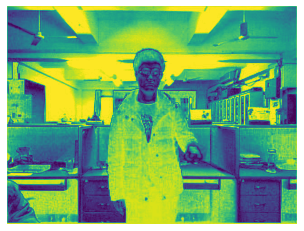

torch.Size([1, 480, 640])


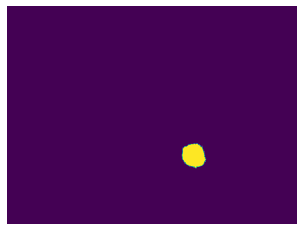

torch.Size([1, 480, 640])


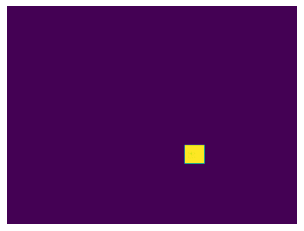

torch.Size([1, 480, 640])


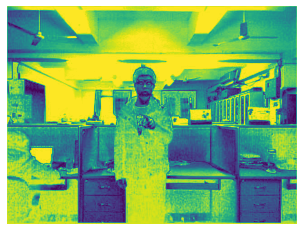

torch.Size([1, 480, 640])


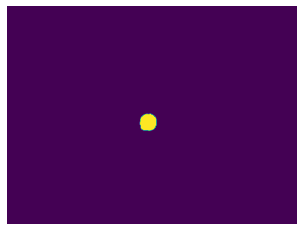

torch.Size([1, 480, 640])


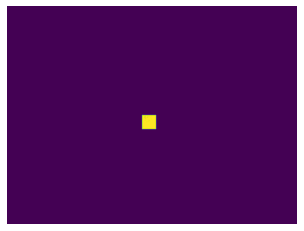

torch.Size([1, 480, 640])


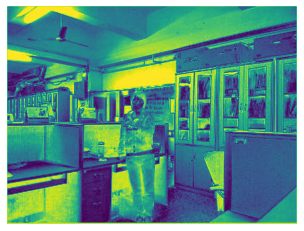

torch.Size([1, 480, 640])


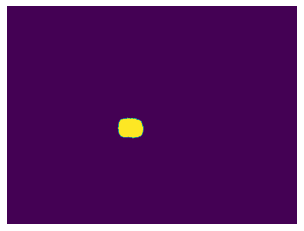

torch.Size([1, 480, 640])


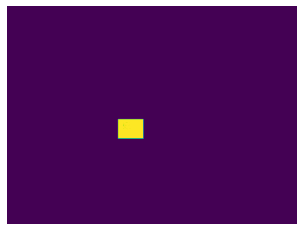

torch.Size([1, 480, 640])


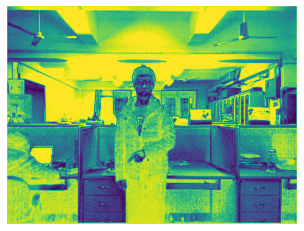

torch.Size([1, 480, 640])


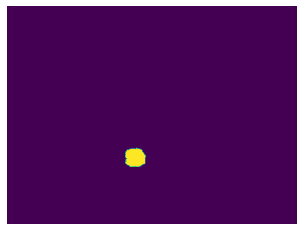

torch.Size([1, 480, 640])


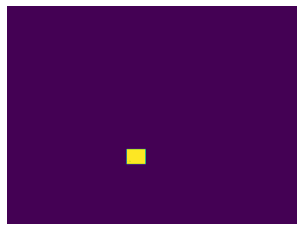

torch.Size([1, 480, 640])


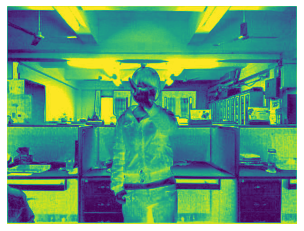

torch.Size([1, 480, 640])


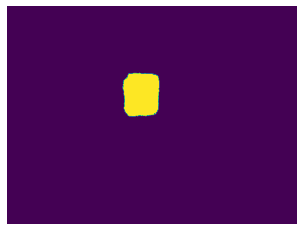

torch.Size([1, 480, 640])


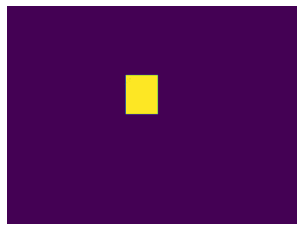

torch.Size([1, 480, 640])


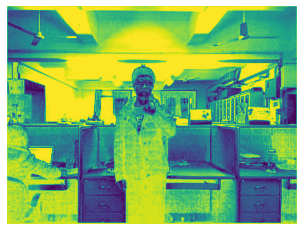

torch.Size([1, 480, 640])


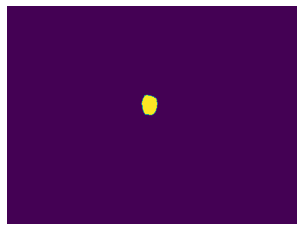

torch.Size([1, 480, 640])


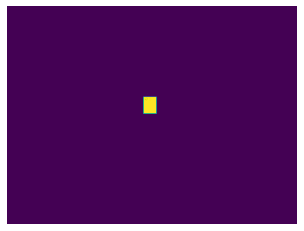

torch.Size([1, 480, 640])


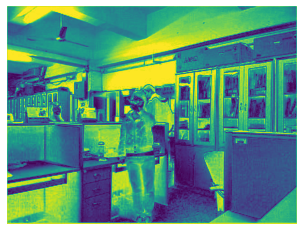

torch.Size([1, 480, 640])


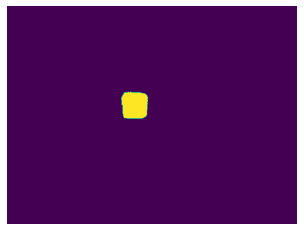

torch.Size([1, 480, 640])


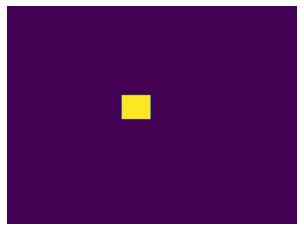

torch.Size([1, 480, 640])


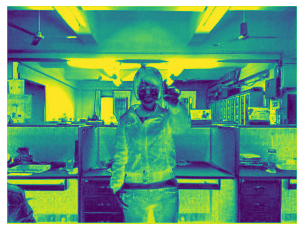

torch.Size([1, 480, 640])


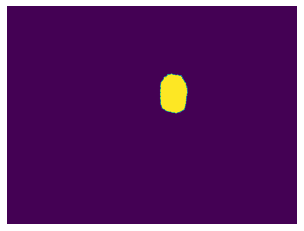

torch.Size([1, 480, 640])


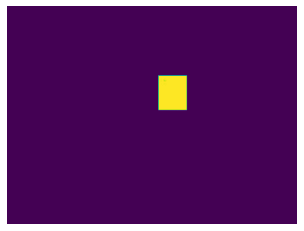

torch.Size([1, 480, 640])


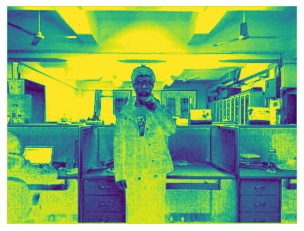

torch.Size([1, 480, 640])


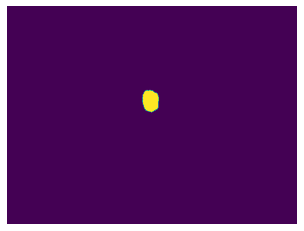

torch.Size([1, 480, 640])


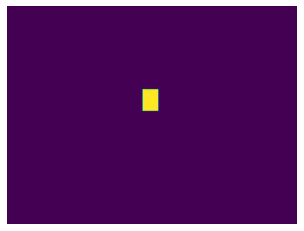

torch.Size([1, 480, 640])


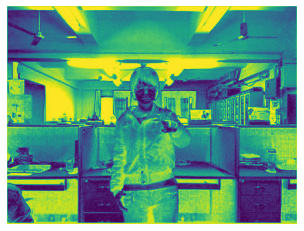

torch.Size([1, 480, 640])


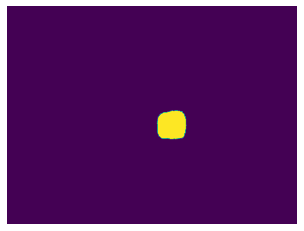

torch.Size([1, 480, 640])


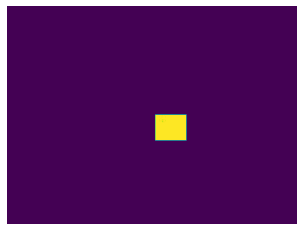

torch.Size([10, 3, 1, 480, 640]) torch.Size([10, 3, 1, 480, 640])
Accuracy = 99.73717331886292%
Precision = 84.76305603981018%
Recall = 89.28819298744202%
torch.Size([1, 480, 640])


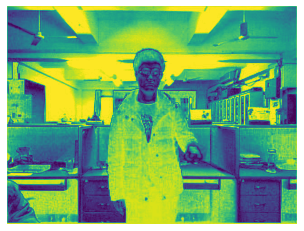

torch.Size([1, 480, 640])


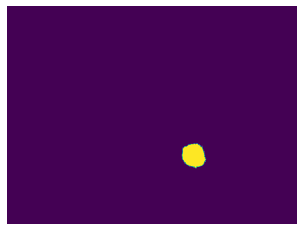

torch.Size([1, 480, 640])


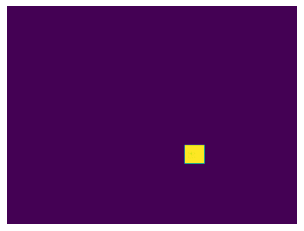

torch.Size([1, 480, 640])


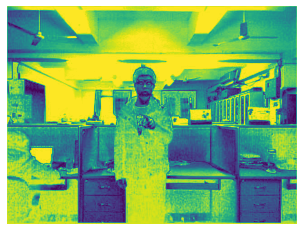

torch.Size([1, 480, 640])


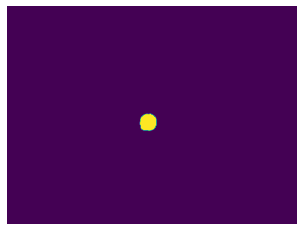

torch.Size([1, 480, 640])


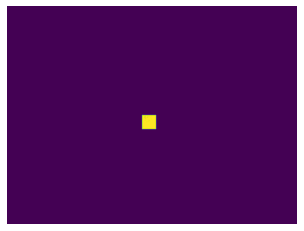

torch.Size([1, 480, 640])


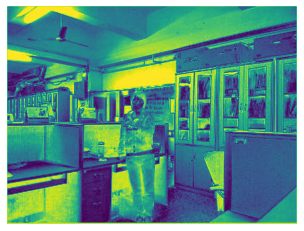

torch.Size([1, 480, 640])


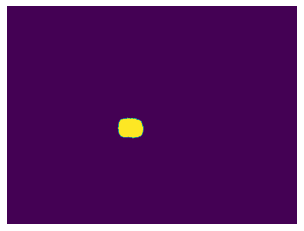

torch.Size([1, 480, 640])


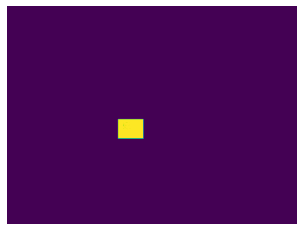

torch.Size([1, 480, 640])


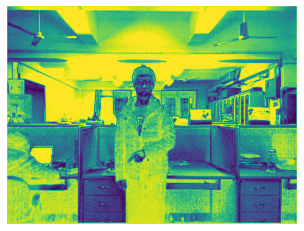

torch.Size([1, 480, 640])


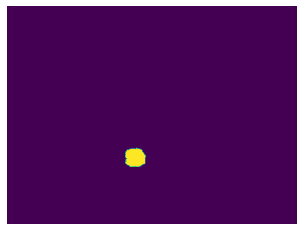

torch.Size([1, 480, 640])


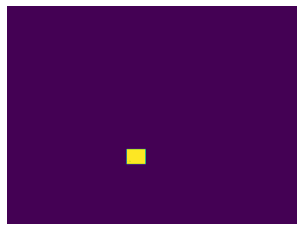

torch.Size([1, 480, 640])


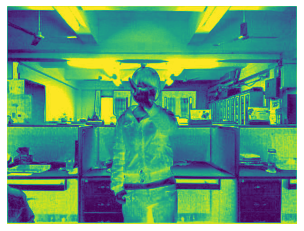

torch.Size([1, 480, 640])


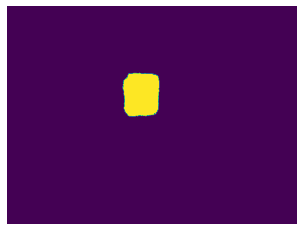

torch.Size([1, 480, 640])


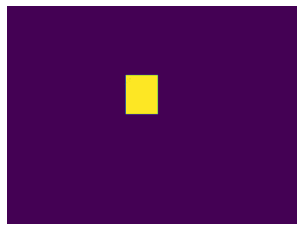

torch.Size([1, 480, 640])


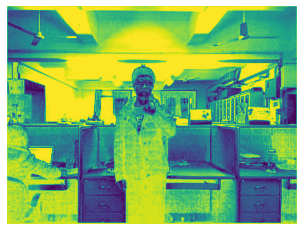

torch.Size([1, 480, 640])


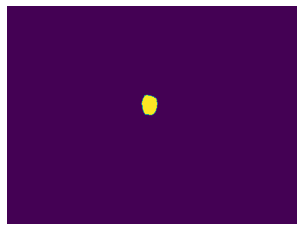

torch.Size([1, 480, 640])


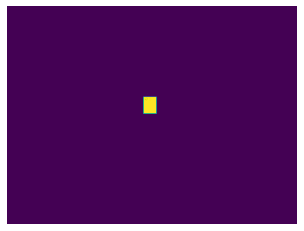

torch.Size([1, 480, 640])


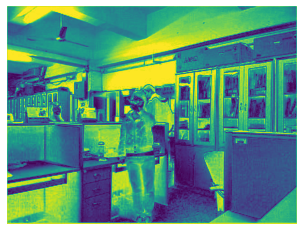

torch.Size([1, 480, 640])


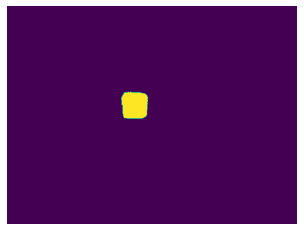

torch.Size([1, 480, 640])


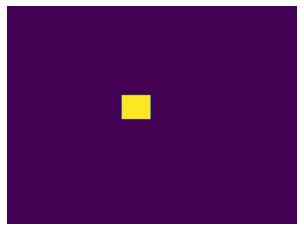

torch.Size([1, 480, 640])


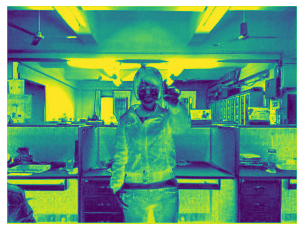

torch.Size([1, 480, 640])


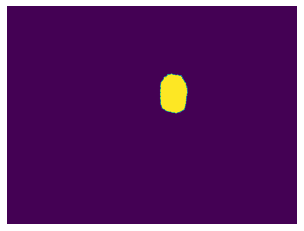

torch.Size([1, 480, 640])


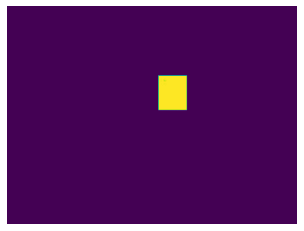

torch.Size([1, 480, 640])


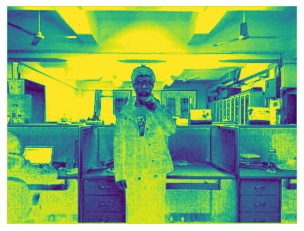

torch.Size([1, 480, 640])


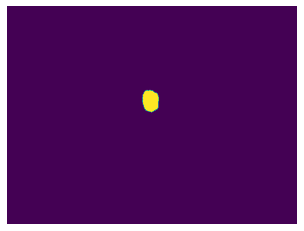

torch.Size([1, 480, 640])


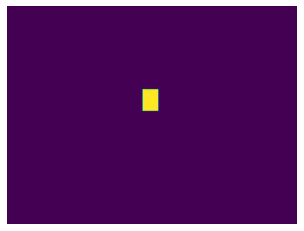

torch.Size([1, 480, 640])


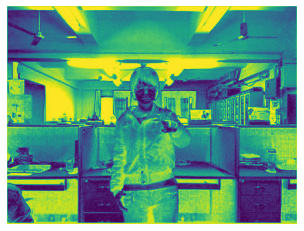

torch.Size([1, 480, 640])


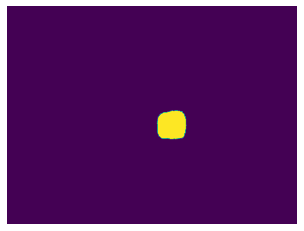

torch.Size([1, 480, 640])


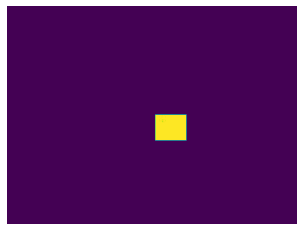

torch.Size([10, 3, 1, 480, 640]) torch.Size([10, 3, 1, 480, 640])
Accuracy = 99.73717331886292%
Precision = 84.76305603981018%
Recall = 89.28819298744202%
torch.Size([1, 480, 640])


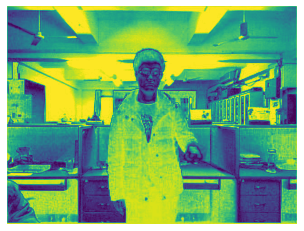

torch.Size([1, 480, 640])


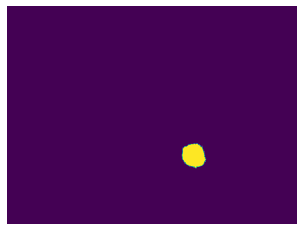

torch.Size([1, 480, 640])


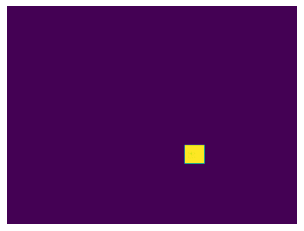

torch.Size([1, 480, 640])


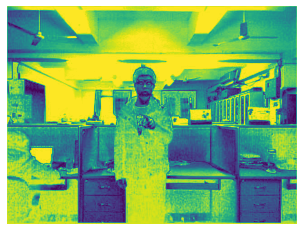

torch.Size([1, 480, 640])


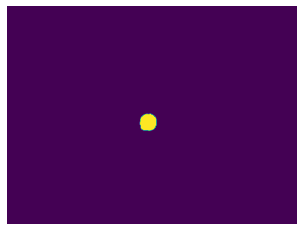

torch.Size([1, 480, 640])


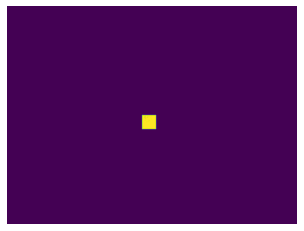

torch.Size([1, 480, 640])


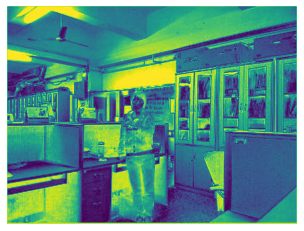

torch.Size([1, 480, 640])


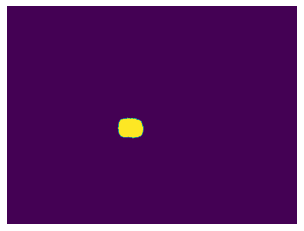

torch.Size([1, 480, 640])


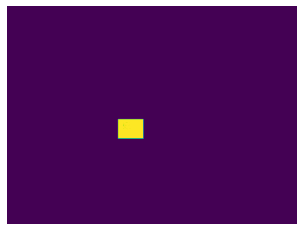

torch.Size([1, 480, 640])


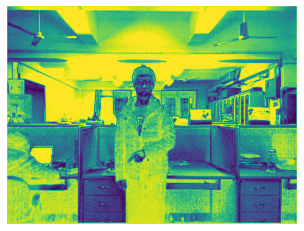

torch.Size([1, 480, 640])


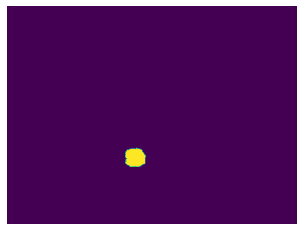

torch.Size([1, 480, 640])


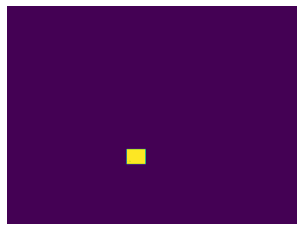

torch.Size([1, 480, 640])


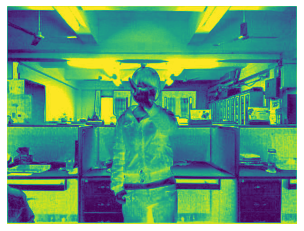

torch.Size([1, 480, 640])


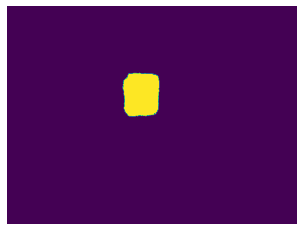

torch.Size([1, 480, 640])


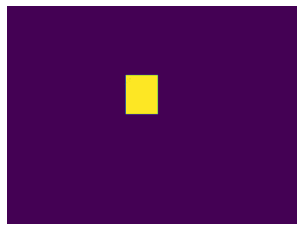

torch.Size([1, 480, 640])


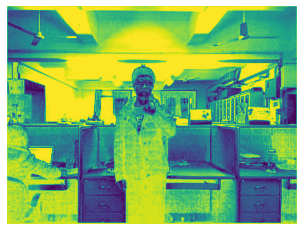

torch.Size([1, 480, 640])


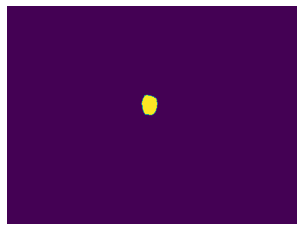

torch.Size([1, 480, 640])


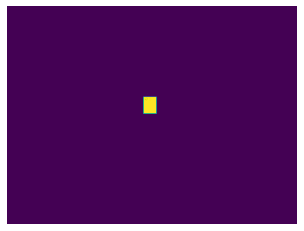

torch.Size([1, 480, 640])


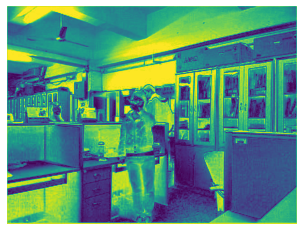

torch.Size([1, 480, 640])


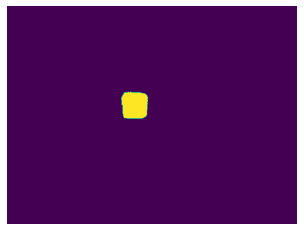

torch.Size([1, 480, 640])


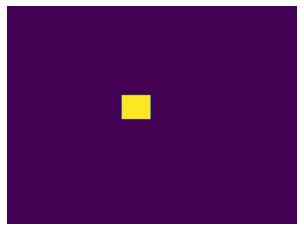

torch.Size([1, 480, 640])


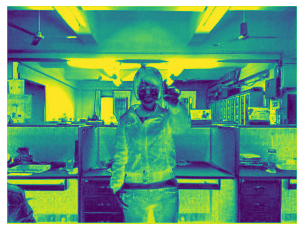

torch.Size([1, 480, 640])


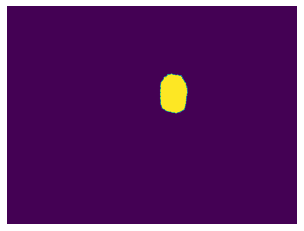

torch.Size([1, 480, 640])


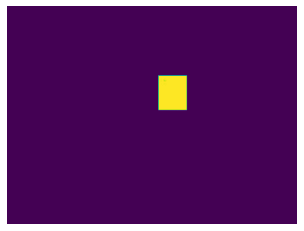

torch.Size([1, 480, 640])


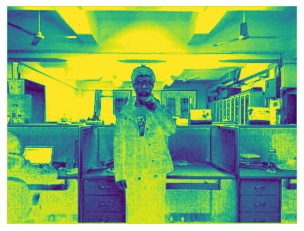

torch.Size([1, 480, 640])


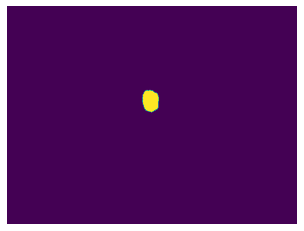

torch.Size([1, 480, 640])


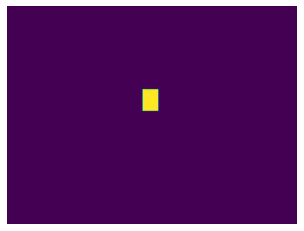

torch.Size([1, 480, 640])


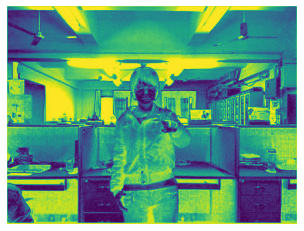

torch.Size([1, 480, 640])


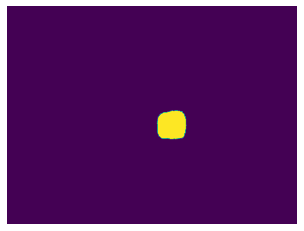

torch.Size([1, 480, 640])


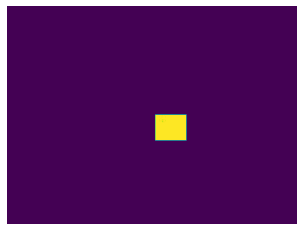

In [14]:
visualizer.visualize_model_output(loader_test, resnet18_notile_full, 30, tile_height=TILE_HEIGHT, tile_width=TILE_WIDTH, device=device)